# AirBNB Data Preparation (Target = price_gte_150)

In this notebook we focus on the data loading, basic exploring, and prepatation.

This notebook follows closely the previous data cleaning toturial from last week. We will be using the same input dataset and producing the same output with one small change - instead of the target being the continuous variable price, we will select the target price_category - and we will be using a logistic regression model instead of a linear regression model to identify where price_gte_150 is true.


## 1.0 Setup


In [1]:
# import numpy and pandas libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
# set random seed to ensure that results are repeatable
np.random.seed(1)

## 2.0 Load data 

In [3]:
# load data
airbnb = pd.read_csv("./data/airbnb (3).csv")

airbnb.head(3)

,host_is_superhost,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,...,guests_included,price_per_extra_person,minimum_nights,number_of_reviews,number_days_btw_first_last_review,review_scores_rating,cancellation_policy,price,price_gte_150,price_category
0,0,0,Roslindale,42.282619,-71.133068,House,Entire home/apt,4,1.5,2.0,...,1,0,2,0,0,NaN,moderate,250,1,gte_226
1,0,1,Roslindale,42.286241,-71.134374,Apartment,Private room,2,1.0,1.0,...,0,0,2,36,804,94.0,moderate,65,0,lte_$75
2,1,1,Roslindale,42.292438,-71.135765,Apartment,Private room,2,1.0,1.0,...,1,20,3,41,2574,98.0,moderate,65,0,lte_$75


## 3.0 Conduct initial exploration of the data

We have a number of input variables and one target variable. For this analysis, the target variable is price.

First, our initial exploration of the data should answer the following questions:
1. How many rows and columns
2. How much of a problem do we have with na's?
3. What types of data are there?
4. What types of data are stored in columns
    1. identify which variables are numeric and may need to be standardized later
    2. identify which variables are categorical and may need to be transformed using and encoders such as one-hot-encoder.
5. Identify errors in the data - this is a common problem with categorical vars where the category is mispelled or spelled differently in some instances.
 

In [4]:
# look at the data
airbnb.head(3) # note that we don't want to dump all the data to the screen

,host_is_superhost,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,...,guests_included,price_per_extra_person,minimum_nights,number_of_reviews,number_days_btw_first_last_review,review_scores_rating,cancellation_policy,price,price_gte_150,price_category
0,0,0,Roslindale,42.282619,-71.133068,House,Entire home/apt,4,1.5,2.0,...,1,0,2,0,0,NaN,moderate,250,1,gte_226
1,0,1,Roslindale,42.286241,-71.134374,Apartment,Private room,2,1.0,1.0,...,0,0,2,36,804,94.0,moderate,65,0,lte_$75
2,1,1,Roslindale,42.292438,-71.135765,Apartment,Private room,2,1.0,1.0,...,1,20,3,41,2574,98.0,moderate,65,0,lte_$75


In [5]:
# generate a basic summary of the data
airbnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3555 entries, 0 to 3554
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   host_is_superhost                  3555 non-null   int64  
 1   host_identity_verified             3555 non-null   int64  
 2   neighbourhood_cleansed             3555 non-null   object 
 3   latitude                           3555 non-null   float64
 4   longitude                          3555 non-null   float64
 5   property_type                      3552 non-null   object 
 6   room_type                          3555 non-null   object 
 7   accommodates                       3555 non-null   int64  
 8   bathrooms                          3541 non-null   float64
 9   bedrooms                           3545 non-null   float64
 10  beds                               3546 non-null   float64
 11  bed_type                           3555 non-null   objec

In [6]:
# generate a statistical summary of the numeric value in the data
airbnb.describe()

,host_is_superhost,host_identity_verified,latitude,longitude,accommodates,bathrooms,bedrooms,beds,Number of amenities,guests_included,price_per_extra_person,minimum_nights,number_of_reviews,number_days_btw_first_last_review,review_scores_rating,price,price_gte_150
count,3555.000000,3555.000000,3555.000000,3555.000000,3555.000000,3541.000000,3545.000000,3546.000000,3555.00000,3555.000000,3555.000000,3555.000000,3555.000000,3555.000000,2755.000000,3555.000000,3555.000000
mean,0.113080,0.727989,42.339973,-71.084874,3.023629,1.215899,1.246544,1.597293,14.85879,1.427004,10.886639,3.116737,19.126582,279.052602,91.891470,166.060478,0.500422
std,0.316735,0.445058,0.024464,0.031614,1.754808,0.492656,0.738440,0.995467,4.82126,1.050204,19.092755,8.273949,35.666178,408.686952,9.548381,103.378456,0.500070
min,0.000000,0.000000,42.235942,-71.171789,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,20.000000,10.000000,0.000000
25%,0.000000,0.000000,42.329875,-71.105183,2.000000,1.000000,1.000000,1.000000,12.00000,1.000000,0.000000,1.000000,1.000000,0.000000,89.000000,85.000000,0.000000
50%,0.000000,1.000000,42.345191,-71.078487,2.000000,1.000000,1.000000,1.000000,15.00000,1.000000,0.000000,2.000000,5.000000,92.000000,94.000000,150.000000,1.000000
75%,0.000000,1.000000,42.354672,-71.062142,4.000000,1.000000,2.000000,2.000000,18.00000,1.000000,20.000000,3.000000,21.000000,402.000000,98.000000,219.000000,1.000000
max,1.000000,1.000000,42.389982,-71.000100,16.000000,6.000000,5.000000,16.000000,30.00000,14.000000,200.000000,300.000000,404.000000,2680.000000,100.000000,650.000000,1.000000


In [7]:
# Check the missing values by summing the total na's for each variable
airbnb.isna().sum()

host_is_superhost                      0
host_identity_verified                 0
neighbourhood_cleansed                 0
latitude                               0
longitude                              0
property_type                          3
room_type                              0
accommodates                           0
bathrooms                             14
bedrooms                              10
beds                                   9
bed_type                               0
Number of amenities                    0
guests_included                        0
price_per_extra_person                 0
minimum_nights                         0
number_of_reviews                      0
number_days_btw_first_last_review      0
review_scores_rating                 800
cancellation_policy                    0
price                                  0
price_gte_150                          0
price_category                         0
dtype: int64

In [8]:
# create a list of these catagorical variables
category_var_list = list(airbnb.select_dtypes(include='object').columns)
category_var_list

['neighbourhood_cleansed',
 'property_type',
 'room_type',
 'bed_type',
 'cancellation_policy',
 'price_category']

In [9]:
# explore the categorical variable values - often there are typos here that need to be fixed.
for cat in category_var_list: # generally, we want to avoid for loops and use a functional style (i.e. list comprehension)
    print(f"Category: {cat} Values: {airbnb[cat].unique()}")

Category: neighbourhood_cleansed Values: ['Roslindale' 'Jamaica Plain' 'Mission Hill' 'Longwood Medical Area'
 'Bay Village' 'Leather District' 'Chinatown' 'North End' 'Roxbury'
 'South End' 'Back Bay' 'East Boston' 'Charlestown' 'West End'
 'Beacon Hill' 'Downtown' 'Fenway' 'Brighton' 'West Roxbury' 'Hyde Park'
 'Mattapan' 'Dorchester' 'South Boston Waterfront' 'South Boston'
 'Allston']
Category: property_type Values: ['House' 'Apartment' 'Condominium' 'Villa' 'Bed & Breakfast' 'Townhouse'
 'Entire Floor' 'Loft' 'Guesthouse' 'Boat' 'Dorm' 'Other' nan 'Camper/RV']
Category: room_type Values: ['Entire home/apt' 'Private room' 'Shared room']
Category: bed_type Values: ['Real Bed' 'Pull-out Sofa' 'Futon' 'Airbed' 'Couch']
Category: cancellation_policy Values: ['moderate' 'flexible' 'strict' 'super_strict_30']
Category: price_category Values: ['gte_226' 'lte_$75' 'btw_$75-$150' 'btw_$151-$225']


### Summary the findings from our initial evaluation of the data

* We have 6 categorical variables
* We have 3 variables that have missing values
* There doesn't seem to be a problem with the catogorical class names.

## 4.0 Process the data

* Conduct any data prepartion that should be done *BEFORE* the data split.
* Split the data.
* Conduct any data preparation that should be done *AFTER* the data split.

### 4.1  Conduct any data prepartion that should be done *BEFORE* the data split

Tasks at this stage include:
1. Drop any columns/features 
2. Decide if you with to exclude any observations (rows) due to missing na's.
2. Conduct proper encoding of categorical variables
    1. You can transform them using dummy variable encoding, one-hot-encoding, or label encoding. 

#### Drop any columns/variables we will not be using

In [10]:
# Our target is price; but there are three related price variableds - price, price_gte_150, 
# and price_category. We need to drop price_gte_150, and price_category
airbnb.drop(['price', 'price_category'], axis=1, inplace = True) # keep price_gte_150 for our target

#### Drop observations with too many NA's

If we want to remove the rows with NA's use the following code that is commented out. For this exercise - we will not drop rows with NA's 

In [11]:
# If we want to remove rows with NA's use the following code:
# airbnb.dropna(axis=0, inplace=True)

In [12]:
# verify that there are now no missing values
# airbnb.isna().sum()

In [13]:
# investigage how many rows remain 
# airbnb.shape

#### Encode our categorical variables

Categorical variables usually have strings for their values. Many machine learning algorithms do not support string values for the input variables. Therefore, we need to replace these string values with numbers. This process is called categorical variable encoding.

In a previous step we identified 5 catagorical variables and found no indication of typos in the class names. Our focus is now on encoding the variables. 

We have three main approaches to encoding variables (these will be discussed in greater detail in class)
* One-Hot-Encoding
* Dummy Encoding
* Label Encoding

In this exercise; we will dummy encode neighbourhood_cleansed, property_type using dummy encoding, and room_type, bed_type and cancelation policy using label encoding. (we will have more discussion on these choices in class).

Before we do our encoding, we must identify if any of our categorical variables have a missing value. We will replace any missing values with the term 'unkown'.

In [14]:
airbnb['property_type'].isna().sum() # check for missing values in this variable/column - we can see there are three for this variable

3

In [15]:
airbnb["property_type"].fillna("unkown", inplace = True)

In [16]:
airbnb['neighbourhood_cleansed'].isna().sum() 

0

In [17]:
airbnb['room_type'].isna().sum() # can see by the results below, no missing values

0

In [18]:
airbnb['bed_type'].isna().sum() # can see by the results below, no missing values

0

In [19]:
airbnb['cancellation_policy'].isna().sum() # can see by the results below, no missing values

0

Now, let's encode neighborhood_cleansed and property_type as dummy variables and room_type, bed_type and cancelation_policy labeled (numeric)

In [20]:
dummies_df = pd.get_dummies(airbnb['neighbourhood_cleansed'], prefix='neighbourhood_cleansed', drop_first=True)

In [21]:
airbnb = airbnb.join(dummies_df)
airbnb.drop('neighbourhood_cleansed', axis=1, inplace = True)

In [22]:
airbnb = airbnb.join(pd.get_dummies(airbnb['property_type'], prefix='property_type', drop_first=True))
airbnb.drop('property_type', axis=1, inplace = True)

In [23]:
labelencoder = LabelEncoder()
airbnb['room_type'] = labelencoder.fit_transform(airbnb['room_type'])
airbnb['bed_type'] = labelencoder.fit_transform(airbnb['bed_type'])
airbnb['cancellation_policy'] = labelencoder.fit_transform(airbnb['cancellation_policy'])

In [24]:
# explore the dataframe columns to verify encoding and dropped columns
airbnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3555 entries, 0 to 3554
Data columns (total 56 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   host_is_superhost                               3555 non-null   int64  
 1   host_identity_verified                          3555 non-null   int64  
 2   latitude                                        3555 non-null   float64
 3   longitude                                       3555 non-null   float64
 4   room_type                                       3555 non-null   int32  
 5   accommodates                                    3555 non-null   int64  
 6   bathrooms                                       3541 non-null   float64
 7   bedrooms                                        3545 non-null   float64
 8   beds                                            3546 non-null   float64
 9   bed_type                                 

### Safe the pre-split processed data to a csv file

In [25]:
airbnb.to_csv('airbnb_presplit_processed.csv', index=False)

### 4.2 Split data (train/test)

In [26]:
# split the data into validation and training set
train_df, test_df = train_test_split(airbnb, test_size=0.3)

# to reduce repetition in later code, create variables to represent the columns
# that are our predictors and target
target = 'price_gte_150'
predictors = list(airbnb.columns)
predictors.remove(target)

### 4.3  Conduct any data prepartion that should be done *AFTER* the data split

We will look at the following:
1) imput any missing numeric values using the mean of the variable/column
2) remove differences of scale by standardizing the numerica variables

#### Impute missing values

In [27]:
numeric_cols_with_nas = list(train_df.isna().sum()[train_df.isna().sum() > 0].index)
numeric_cols_with_nas

['bathrooms', 'bedrooms', 'beds', 'review_scores_rating']

We can see from the code above that there are 4 variables (columns) that contain missing numeric values (we've already taken care of any missing values in the catagorical variables earlier).

In [28]:
imputer = SimpleImputer(strategy="median")

train_df[numeric_cols_with_nas] = imputer.fit_transform(train_df[numeric_cols_with_nas])
test_df[numeric_cols_with_nas] = imputer.transform(test_df[numeric_cols_with_nas])

#### Standardize numeric values

Now, let's create a common scale between the numberic columns by standardizing each numeric column

In [29]:
# create a standard scaler and fit it to the training set of predictors
scaler = preprocessing.StandardScaler()
cols_to_stdize = ['latitude', 'longitude', 'accommodates', 
                   'bathrooms', 'bedrooms', 'beds', 'Number of amenities', 
                   'guests_included', 'price_per_extra_person', 'minimum_nights', 
                   'number_of_reviews', 'number_days_btw_first_last_review', 
                   'review_scores_rating']                
               
# Transform the predictors of training and validation sets
train_df[cols_to_stdize] = scaler.fit_transform(train_df[cols_to_stdize]) # train_predictors is not a numpy array


test_df[cols_to_stdize] = scaler.transform(test_df[cols_to_stdize]) # validation_target is now a series object


## 5.0 Save the data

In [30]:
train_X = train_df[predictors]
train_y = train_df[target] # train_target is now a series objecttrain_df.to_csv('airbnb_train_df.csv', index=False)
test_X = test_df[predictors]
test_y = test_df[target] # validation_target is now a series object

train_df.to_csv('./data/airbnb_train_df_price_gte_150.csv', index=False)
train_X.to_csv('./data/airbnb_train_X_price_gte_150.csv', index=False)
train_y.to_csv('./data/airbnb_train_y_price_gte_150.csv', index=False)
test_df.to_csv('./data/airbnb_test_df_price_gte_150.csv', index=False)
test_X.to_csv('./data/airbnb_test_X_price_gte_150.csv', index=False)
test_y.to_csv('./data/airbnb_test_y_price_gte_150.csv', index=False)

## Loading the price150 data

In [2]:
X_train = pd.read_csv("./data/airbnb_train_X_price_gte_150.csv")
X_test = pd.read_csv("./data/airbnb_test_X_price_gte_150.csv")
y_train = pd.read_csv("./data/airbnb_train_y_price_gte_150.csv")
y_test = pd.read_csv("./data/airbnb_test_y_price_gte_150.csv")

## 3. Model the data

First, we will create a dataframe to hold all the results of our models.

In [3]:
performance = pd.DataFrame({"model": [], "Accuracy": [], "Precision": [], "Recall": [], "F1": []})

### 3.1 Fit and test a Logistic Regression model

### 3.1 Fit a SVM classification model using linear kernal

In [4]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix



### 3.3 Fit a SVM classification model using polynomial kernal

In [5]:
svm_poly_model = SVC(kernel="poly", degree=3, coef0=1, C=10)
_ = svm_poly_model.fit(X_train, np.ravel(y_train))

In [6]:
model_preds = svm_poly_model.predict(X_test)
c_matrix = confusion_matrix(y_test, model_preds)
TP = c_matrix[1][1]
TN = c_matrix[0][0]
FP = c_matrix[0][1]
FN = c_matrix[1][0]
performance= pd.concat([performance, pd.DataFrame({'model':"poly svm", 
                                                    'Accuracy': [(TP+TN)/(TP+TN+FP+FN)], 
                                                    'Precision': [TP/(TP+FP)], 
                                                    'Recall': [TP/(TP+FN)], 
                                                    'F1': [2*TP/(2*TP+FP+FN)]
                                                     }, index=[0])])

In [7]:

performance.sort_values(by=['Precision'],ascending= False)

,model,Accuracy,Precision,Recall,F1
0,poly svm,0.867854,0.855839,0.883239,0.869323


# Analysis for SVM poly

SVM is a classification algorithm that has achieved significant performance. It categorizes the data by locating the optimum hyperplane and optimizing the distance between points. In order to demonstrate how it works with support vector machines, a kernel function will be introduced. We have used poly kernal.

In SVM classification issues when the data is not linearly separable, the polynomial kernel is frequently utilized.
The polynomial kernel has a number of parameters that can be tuned to improve its performance, including the degree of the polynomial and the coefficient of the polynomial.

Our target churn is in binary.
The poly svm model gives best results in majority of the metrics.

Since we were dealing with the data consisting of multiple predictors; I would like to consider precision metric 

**Therefore, the SVM with poly kernel is the best model for our data.**

## Gridsearch & Decision tree

In [8]:
from sklearn.tree import DecisionTreeClassifier 
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

## NOTE: In this next section, GridSearch will use K Fold Cross Validation 

K-Fold cross validation is used to avoid overfitting. 

In k-fold cross-validation, the original sample is randomly partitioned into k equal sized subsamples. Of the k subsamples, a single subsample is retained as the validation data for testing the model, and the remaining k − 1 subsamples are used as training data. The cross-validation process is then repeated k times, with each of the k subsamples used exactly once as the validation data. The k results can then be averaged to produce a single estimation. 

![cross validation diagram](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)


## Model the data

Conduct an initial random search across a wide range of possible parameters.

In [ ]:
score_measure = "precision"
kfolds = 5

param_grid = {
    'min_samples_split': np.arange(1,100),  
    'min_samples_leaf': np.arange(1,100),
    'min_impurity_decrease': np.arange(0.0001, 0.01, 0.0005),
    'max_leaf_nodes': np.arange(5, 100), 
    'max_depth': np.arange(1,50), 
    'criterion': ['entropy', 'gini'],
}


NameError: name 'np' is not defined

In [15]:

dtree = DecisionTreeClassifier()
rand_search = RandomizedSearchCV(estimator = dtree, param_distributions=param_grid, cv=kfolds, n_iter=300,
                           scoring=score_measure, verbose=1, n_jobs=-1,  # n_jobs=-1 will utilize all available CPUs 
                           return_train_score=True)


In [16]:

_ = rand_search.fit(X_train, y_train)

print(f"The best {score_measure} score is {rand_search.best_score_}")
print(f"... with parameters: {rand_search.best_params_}")

bestRecallTree = rand_search.best_estimator_

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
The best precision score is 0.8553701168468061
... with parameters: {'min_samples_split': 30, 'min_samples_leaf': 23, 'min_impurity_decrease': 0.0021, 'max_leaf_nodes': 91, 'max_depth': 35, 'criterion': 'gini'}


C:\Users\Bhargav Lakkireddy\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 1500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Bhargav Lakkireddy\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Bhargav Lakkireddy\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 937, in fit
    super().fit(
  File "C:\Users\Bhargav Lakkireddy\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 250, in fit
    raise ValueError(
ValueError: min_samples_split

In [100]:
c_matrix = confusion_matrix(y_test, rand_search.predict(X_test))
TP = c_matrix[1][1]
TN = c_matrix[0][0]
FP = c_matrix[0][1]
FN = c_matrix[1][0]
print(f"Accuracy={(TP+TN)/(TP+TN+FP+FN):.7f} Precision={TP/(TP+FP):.7f} Recall={TP/(TP+FN):.7f} F1={2*TP/(2*TP+FP+FN):.7f}")

Accuracy=0.8397376 Precision=0.8202847 Recall=0.8681733 F1=0.8435499


Conduct an exhaustive search across a smaller range of parameters around the parameters found in the initial random search.

In [24]:
score_measure = "precision"
kfolds = 5

param_grid = {
    'min_samples_split': np.arange(28,32),  
    'min_samples_leaf': np.arange(20,26),
    'min_impurity_decrease': np.arange(0.0020, 0.0026, 0.0001),
    'max_leaf_nodes': np.arange(88,96), 
    'max_depth': np.arange(32,38), 
    'criterion': ['gini'],
}

dtree = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator = dtree, param_grid=param_grid, cv=kfolds, 
                           scoring=score_measure, verbose=1, n_jobs=-1,  # n_jobs=-1 will utilize all available CPUs 
                           return_train_score=True)

_ = grid_search.fit(X_train, y_train)

print(f"The best {score_measure} score is {grid_search.best_score_}")
print(f"... with parameters: {grid_search.best_params_}")

bestRecallTree = grid_search.best_estimator_

Fitting 5 folds for each of 6912 candidates, totalling 34560 fits
The best precision score is 0.8584728930092839
... with parameters: {'criterion': 'gini', 'max_depth': 32, 'max_leaf_nodes': 88, 'min_impurity_decrease': 0.0021999999999999997, 'min_samples_leaf': 20, 'min_samples_split': 28}


In [25]:
c_matrix = confusion_matrix(y_test, grid_search.predict(X_test))
TP = c_matrix[1][1]
TN = c_matrix[0][0]
FP = c_matrix[0][1]
FN = c_matrix[1][0]
print(f"Accuracy={(TP+TN)/(TP+TN+FP+FN):.7f} Precision={TP/(TP+FP):.7f} Recall={TP/(TP+FN):.7f} F1={2*TP/(2*TP+FP+FN):.7f}")

Accuracy=0.8462980 Precision=0.8379374 Recall=0.8568738 F1=0.8472998


## 5.0 Importance of features

In [20]:
np.round(grid_search.best_estimator_.feature_importances_,2)

array([0.  , 0.  , 0.06, 0.1 , 0.71, 0.01, 0.02, 0.07, 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

## 6.0 Diagrams of DTrees

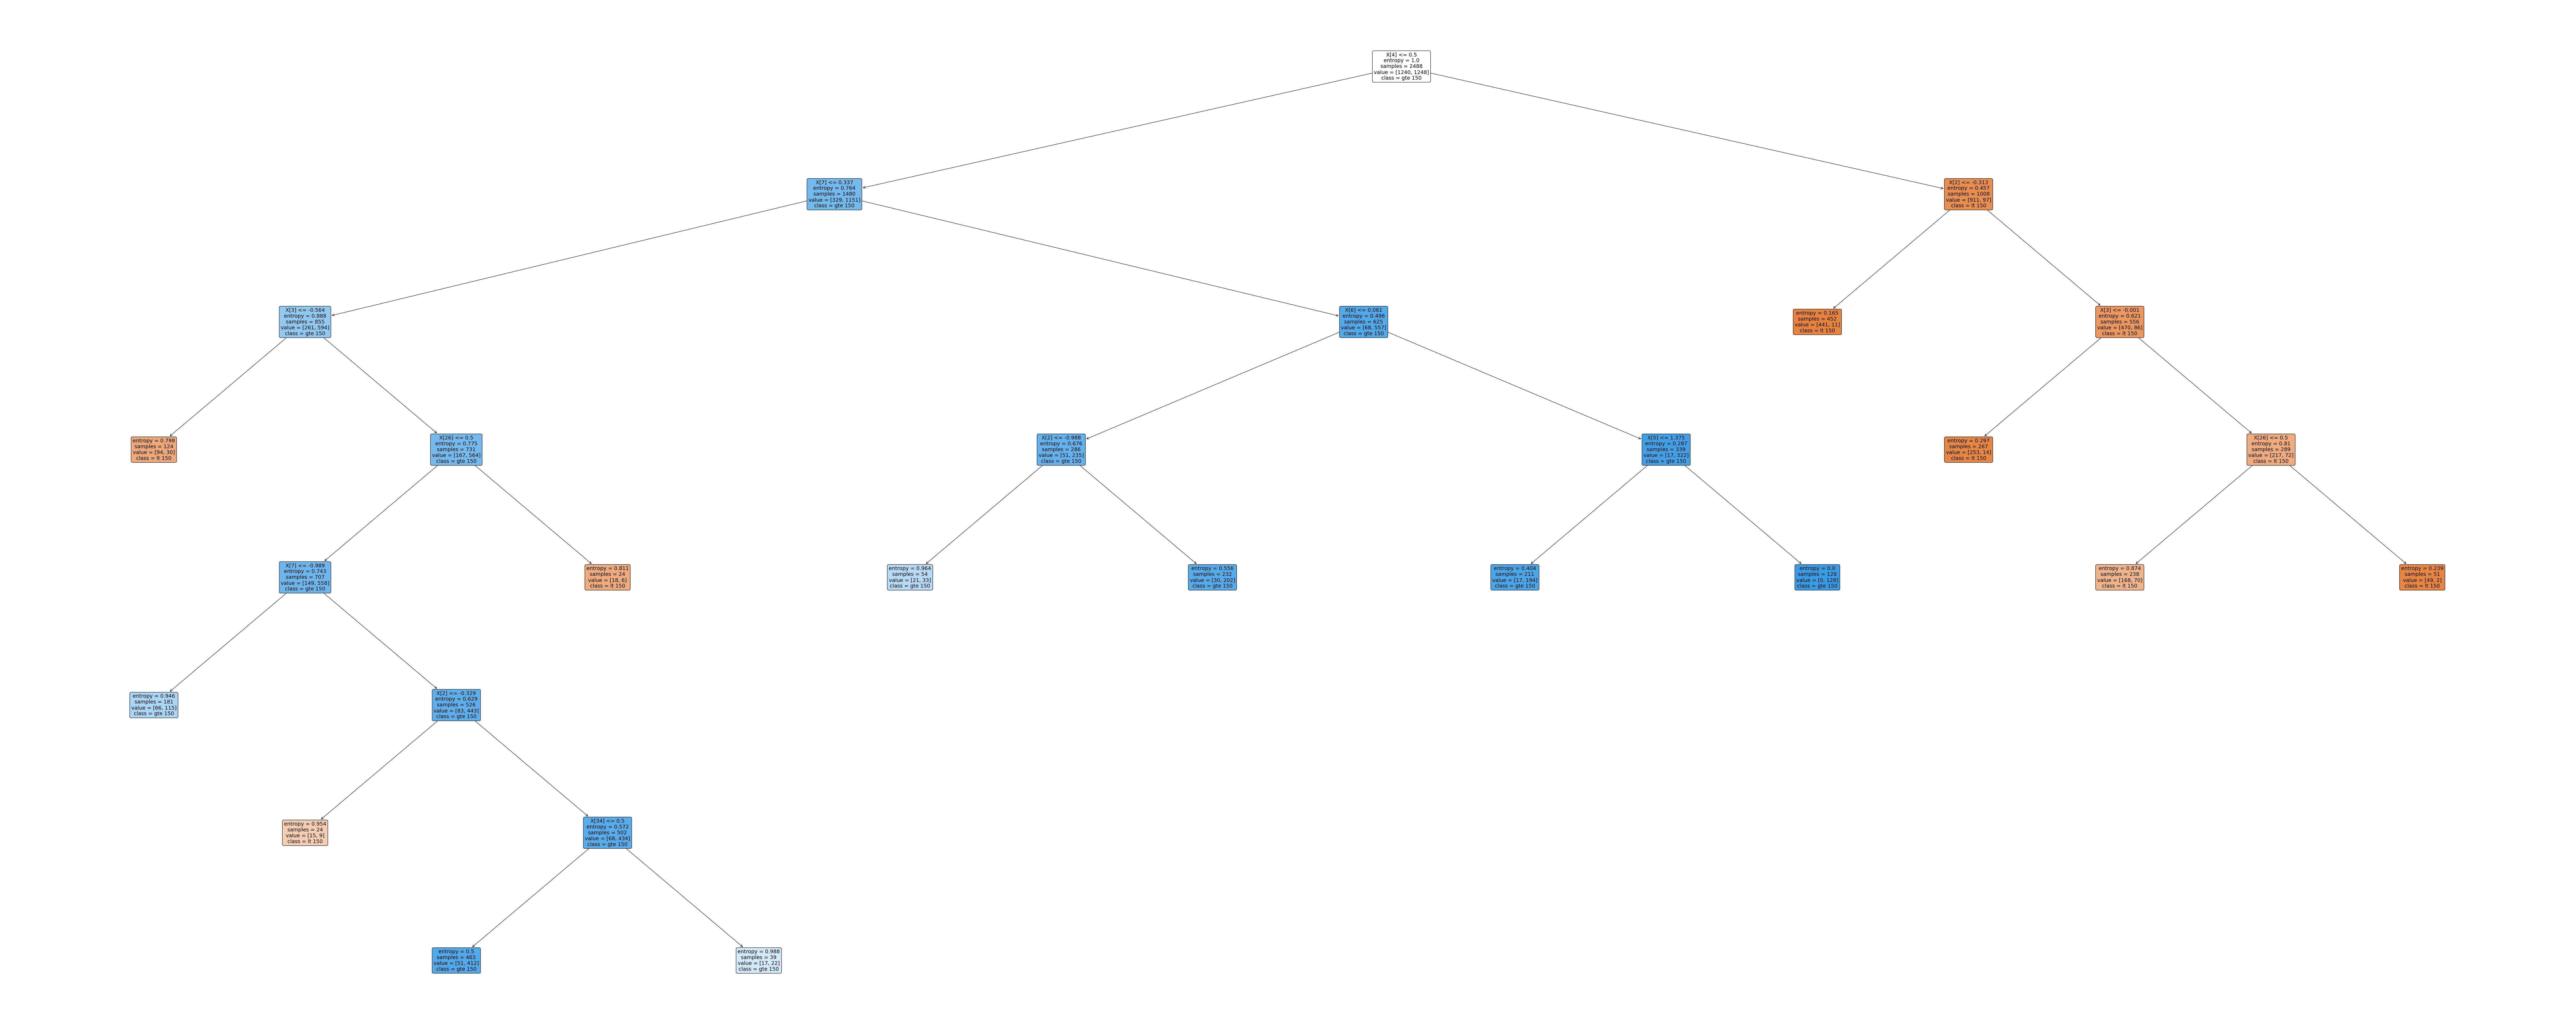

In [21]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(125,50))
tree = plot_tree(grid_search.best_estimator_, 
              #feature_names=train_inputs.columns.values, # our feature names are stripped from the data set
              class_names=['lt 150', 'gte 150'], 
              filled=True, 
              rounded=True, 
              fontsize=14)

# DISCUSSION

For our decision tree, grid search models we have set our score_measure as precision for our airbnb 150 dataset, as compared to the original dataset of airbnb where the target was price and it was continous, now that is not the case for our current dataset.

 By considering precision we should prioritize the accuracy of a model's positive predictions over other metrics. Precision is a measure of how many true positive predictions the model makes compared to the total number of positive predictions. By focusing on precision, the goal is to minimize the number of false positives even if this means sacrificing some true positives. This approach can be useful in applications where false positives can have serious consequences, such as in medical diagnosis or fraud detection.

The best precision score is 0.85 for training data in random search however for our test data the best precision is 0.83

However, we have altered and tuned the parameters according to the computing capability of my current system, as very high values tend to throw up overflow errors, we have chose number of iterations to 300 and changed the range of min samples, depth, impurity and other parameters, as the computational process takes a lot of time and in some cases might result in overflow.

These results are relatively very close considering the number of iterations are different and the min splits differ. The gridsearch has parameters have been tuned accordingly from what we had received from the random search results as optimal paramters. The grid search has done over 34000 fits with 5 folds.

The performance of Support Vector Machine (SVM) models versus Decision Trees depends on several factors, including the data complexity, the problem being addressed, and the hyperparameters used in the models. SVM models tend to perform well when the data is complex and the decision boundary is nonlinear, while Decision Trees can be effective when the data is simpler and the decision boundary is more easily separable. Decision Trees are also more interpretable than SVMs. Ultimately, the choice between the two models will depend on the specific problem at hand, as well as other considerations such as model complexity, training time, and interpretability. It is usually recommended to try both models and compare their performance before selecting the one that works best for a given problem.

Comparing the results of DT random search, grid search their respective precision scores are 0.82 and 0.83

The SVM with poly kernel performed better for this dataset as we can see the precision is 0.85